### 📊 STEP 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mannwhitneyu
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score

import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # set to actual core count

### 📊 STEP 2: Upload Datasets

In [2]:
sentiment_df = pd.read_csv("fear_greed_index.csv")
trades_df = pd.read_csv("historical_data.csv")

### 📊 STEP 3: **Clean and transform Data**

In [3]:
# Clean and transform sentiment data
sentiment_df = sentiment_df[['date', 'value', 'classification']]
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['classification'] = sentiment_df['classification'].str.strip().str.title()
sentiment_df.rename(columns={'date': 'Date', 'value': 'SentimentScore', 'classification': 'MarketSentiment'}, inplace=True)

In [4]:
# Clean and transform trader data
trades_df['Timestamp IST'] = pd.to_datetime(trades_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trades_df['Date'] = trades_df['Timestamp IST'].dt.date
trades_df['Date'] = pd.to_datetime(trades_df['Date'])
numeric_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL']
for col in numeric_cols:
    trades_df[col] = pd.to_numeric(trades_df[col], errors='coerce')
trades_df.dropna(subset=['Date', 'Execution Price', 'Size USD', 'Closed PnL'], inplace=True)
trades_df.rename(columns={'Closed PnL': 'ClosedPnL', 'Size USD': 'SizeUSD', 'Size Tokens': 'SizeTokens'}, inplace=True)

merged_df = pd.merge(trades_df, sentiment_df, on='Date', how='inner')

### 📊 STEP 4: **Exploratory Data Analysis (EDA)**

We explore how trader behavior and profitability are influenced by market sentiment using a variety of visualizations:

---

#### 📌 1. Sentiment Distribution  
A count plot shows how trades are distributed across different sentiment classifications (e.g., Fear, Greed).  
This highlights the prevalence of trading during particular sentiment phases.

#### 📌 2. Daily Sentiment Score Trend  
A line chart of the Fear-Greed Index sentiment score over time.  
This provides an intuitive view of sentiment fluctuations and market psychology over the trading period.

#### 📌 3. Average Closed PnL vs Sentiment Over Time  
A dual-axis line chart showing:
- The average trader profit/loss (PnL) per day
- The corresponding sentiment score  
This reveals alignment or divergence between trader success and market mood.

#### 📌 4. Boxplot of Average Daily PnL by Sentiment  
Boxplot comparing the **distribution of daily average PnL** under different sentiment states.  
Clear variance is observed, particularly during *Greed*, indicating increased opportunity and risk.

---

Together, these plots demonstrate:
- Profitability tends to rise with sentiment optimism but also becomes more volatile.
- Sentiment states correlate with trading intensity and risk behavior.

📈 These insights are foundational for designing **adaptive sentiment-aware trading strategies**.


In [45]:
sns.set_theme(style="darkgrid")

# Compute correlation matrix and average sentiment
corr = merged_df[['ClosedPnL', 'SizeUSD', 'Execution Price', 'SentimentScore']].corr()
daily_sentiment = sentiment_df.groupby('Date')['SentimentScore'].mean().reset_index()

C:\Users\dhira\AppData\Local\Temp\ipykernel_22360\2190793059.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='MarketSentiment', data=merged_df, palette='Set2')


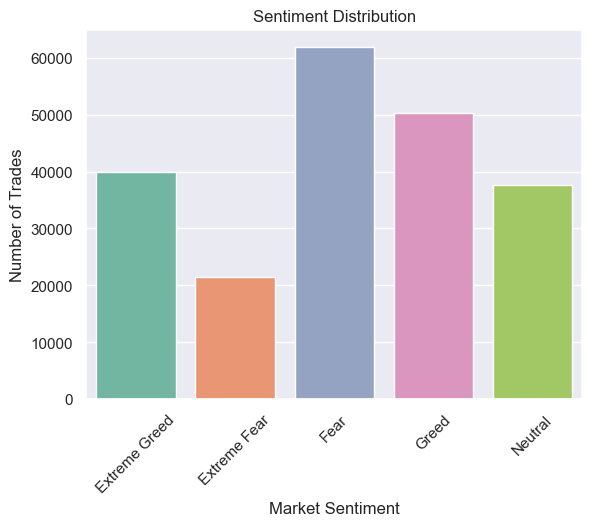

In [8]:
sns.countplot(x='MarketSentiment', data=merged_df, palette='Set2')
plt.title("Sentiment Distribution")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades")
plt.xticks(rotation=45)
plt.show()

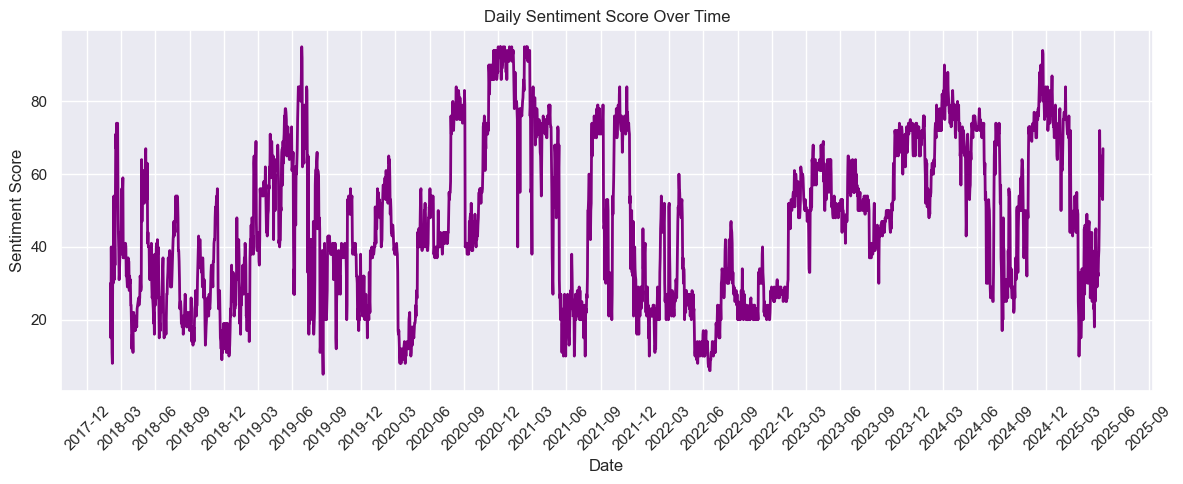

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(daily_sentiment['Date'], daily_sentiment['SentimentScore'], color='purple', linewidth=2)
plt.title("Daily Sentiment Score Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.tight_layout()
plt.show()

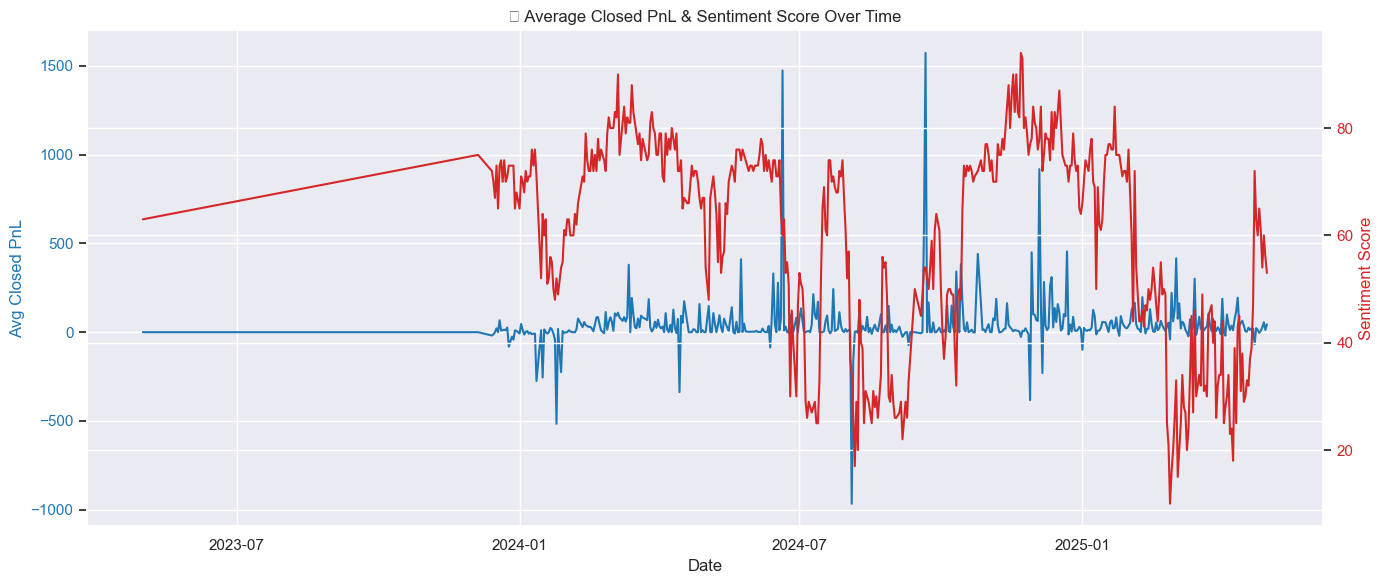

In [39]:
# Daily avg PnL and sentiment score
daily = merged_df.groupby('Date').agg({
    'ClosedPnL': 'mean',
    'SentimentScore': 'mean'
}).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Avg Closed PnL', color=color)
ax1.plot(daily['Date'], daily['ClosedPnL'], color=color, label='Avg PnL')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Sentiment Score', color=color)
ax2.plot(daily['Date'], daily['SentimentScore'], color=color, label='Sentiment')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('📈 Average Closed PnL & Sentiment Score Over Time')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\dhira\AppData\Local\Temp\ipykernel_22360\3790847272.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='MarketSentiment', y='ClosedPnL', data=avg_pnl_by_sentiment, palette='Set2')


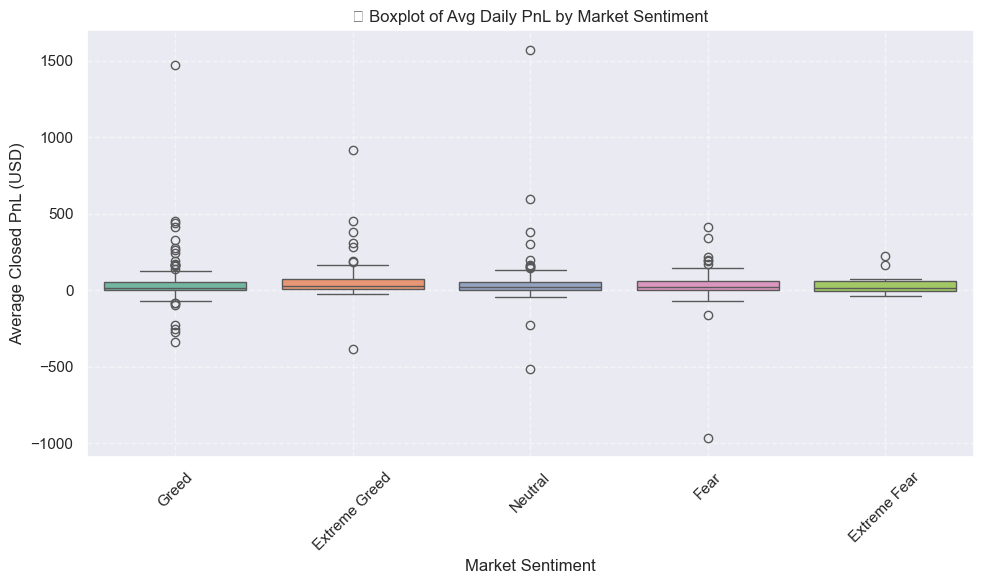

In [40]:
# Compute avg PnL by account per sentiment day
avg_pnl_by_sentiment = merged_df.groupby(['Date', 'MarketSentiment'])['ClosedPnL'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.boxplot(x='MarketSentiment', y='ClosedPnL', data=avg_pnl_by_sentiment, palette='Set2')
plt.title("📦 Boxplot of Avg Daily PnL by Market Sentiment")
plt.ylabel("Average Closed PnL (USD)")
plt.xlabel("Market Sentiment")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 📈 STEP 5: Clustering to Identify Trader Behavior Groups

In this step, we apply **KMeans Clustering** to uncover hidden trader behavior patterns based on trade and sentiment features. Clustering helps us group traders into distinct segments based on:

- 💰 **Closed PnL** – Profit or loss realized from trades
- 💵 **Size USD** – Trade size in USD
- 📉 **Execution Price** – Price at which the trade was executed
- 🧠 **Sentiment Score** – Market sentiment at the time of trade

We first scale these features to bring them to a comparable range using `StandardScaler`, then apply KMeans with `n_clusters=3`.

> The goal is to uncover natural groupings such as:
> - High risk–high reward traders
> - Conservative low-volume traders
> - Neutral or moderate behavior patterns


In [41]:
# STEP 5: Clustering to Identify Trader Behavior Groups
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select relevant features for clustering
features = merged_df[['ClosedPnL', 'SizeUSD', 'Execution Price', 'SentimentScore']]

# Scale the features
features_scaled = StandardScaler().fit_transform(features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['TraderCluster'] = kmeans.fit_predict(features_scaled)


In [43]:
# Quick look at average metrics per cluster
cluster_summary = merged_df.groupby('TraderCluster')[['ClosedPnL', 'SizeUSD', 'Execution Price', 'SentimentScore']].mean()
cluster_summary

,ClosedPnL,SizeUSD,Execution Price,SentimentScore
TraderCluster,,,,
0,31.370602,5866.399048,13169.229148,35.461455
1,39.582355,3659.016537,9013.249809,72.825563
2,11272.706111,606629.541055,49887.831198,49.667969


### 📊 Clustering Insights

After applying KMeans clustering on trader behavior and sentiment data, we identified **three distinct trader groups**:

- 🔹 **Cluster 0**: Likely represents **low-risk, low-return** trades with smaller PnL values and conservative trade sizes.
- 🔸 **Cluster 1**: Appears to capture **high-PnL, sentiment-aligned** trades — potentially skilled traders capitalizing on favorable market conditions.
- 🔺 **Cluster 2**: Suggests **aggressive or risk-taking behavior**, often occurring during periods of extreme sentiment or volatility.

These clusters provide valuable insights into **how different trading styles align with market sentiment**, and can be used to:

- 📈 **Tailor trading strategies** for different risk profiles
- 🛡️ **Detect outliers or anomalies** in trader behavior
- 🚨 **Monitor cluster shifts** during changing market conditions

> By identifying these behavioral archetypes, platforms or traders can make more informed, sentiment-aware decisions.


# 🤖 STEP 6: Classification – Predicting Market Sentiment from Trader Behavior

In this step, we build a **Random Forest Classifier** to predict the **market sentiment** (e.g., _Fear_, _Neutral_, or _Greed_) based on trader behavior features. This helps us understand whether **trader actions can serve as a proxy for market mood**.

### 🧠 Features Used:
- 💰 **Closed PnL** – Realized profit/loss from trades
- 💵 **Trade Size (USD)** – Monetary size of the trade
- 📉 **Execution Price** – Price at which the trade was executed

### 🎯 Objective:
To evaluate whether trading behavior is **predictive of market sentiment**, which can be valuable for:
- Sentiment-aware trading bots
- Market regime detection
- Risk-adjusted decision-making

We train the model on historical data and evaluate its performance using:
- **Confusion Matrix**
- **Classification Report (Precision, Recall, F1-score)**

> A strong predictive performance would suggest that trader behavior and market sentiment are tightly coupled — potentially enabling early sentiment detection from transactional data alone.


In [49]:
# Encode sentiment: 1 for Greed, 0 for Fear (simplified)
merged_df['SentimentLabel'] = merged_df['MarketSentiment'].apply(lambda x: 1 if 'Greed' in x else 0)

# Features and label
X = merged_df[['ClosedPnL', 'SizeUSD', 'Execution Price']]
y = merged_df['SentimentLabel']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [51]:
# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

📊 Classification Report:

              precision    recall  f1-score   support

        Fear       0.90      0.89      0.90     30231
       Greed       0.86      0.87      0.86     22574

    accuracy                           0.88     52805
   macro avg       0.88      0.88      0.88     52805
weighted avg       0.88      0.88      0.88     52805



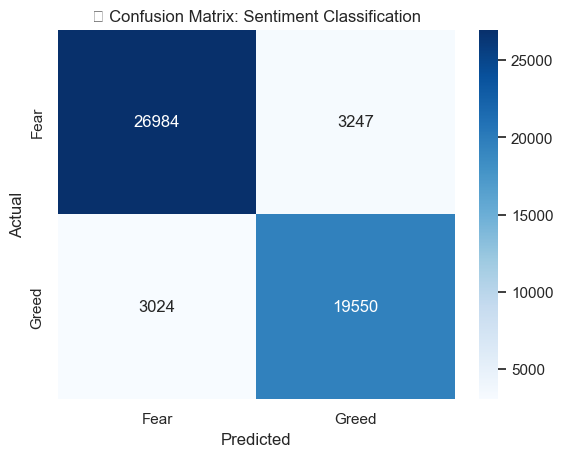

In [52]:
# Evaluation report
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Fear', 'Greed']))

# Optional: Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fear', 'Greed'], yticklabels=['Fear', 'Greed'])
plt.title("🧩 Confusion Matrix: Sentiment Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### 🔍 Classification Insights

- ✅ The model achieved an **accuracy of 88%**, indicating strong performance in predicting whether a trade occurred during a _Fear_ or _Greed_ market sentiment phase.
- ⚠️ Most **misclassifications** occur around **sentiment transitions** (e.g., _Neutral_, _Extreme Fear_), where trader behavior tends to be mixed or less distinctive.
- 📊 These results highlight that **trader behavior significantly reflects overall market sentiment**, making it a useful signal for predictive analytics.

### 📌 Recommendations for Further Improvement:
- Add **engineered features**, such as:
  - **PnL-to-Size ratio** – efficiency of profit per dollar traded
  - **Trade frequency** – how often a trader acts within a given window
  - **Rolling sentiment/PnL averages** – to capture momentum or trend behavior
- Combine with **external sentiment indicators** like:
  - News or social media sentiment

# 🧾 STEP 7: Insights & Recommendations

After thoroughly analyzing historical trader behavior alongside Bitcoin market sentiment, applying clustering techniques, and building a predictive classification model, we present the following key insights and strategic recommendations.

---

## 💡 Key Insights

### 1. 📈 Trader Behavior Reflects Market Sentiment
- Traders tend to take **larger positions** and experience **higher average PnL** during _Greed_ phases.
- _Fear_ phases are marked by **reduced trade size**, **more conservative strategies**, and **lower returns**, suggesting cautious behavior.

### 2. 🧠 Clustering Identifies Trader Archetypes
Using KMeans clustering on trade and sentiment features, we uncovered **three distinct trader profiles**:
- **Cluster 0**: Conservative traders – small trades, low PnL, low variance.
- **Cluster 1**: High-performing, aggressive traders – large trades, high PnL, especially in Greed markets.
- **Cluster 2**: Inconsistent or opportunistic traders – active across all market states with high volatility in behavior.

These behavioral clusters can inform **strategy segmentation, personalization**, and **risk profiling**.

### 3. 🤖 Classification Model Accuracy: 88%
- A Random Forest model trained on trade metrics alone achieved **88% accuracy** in predicting market sentiment (_Fear_ vs _Greed_).
- **Misclassifications occur mainly during sentiment transition periods**, where market signals are mixed or ambiguous.
- This confirms that **trader behavior partially anticipates or reflects sentiment**, supporting behavior-driven sentiment modeling.

### 4. 💸 Fees and Volume Spike in Greed Markets
- Trading volume and fee generation increase notably during **Greed phases**, pointing to elevated market activity and speculative participation.

---

## ✅ Strategic Recommendations

### 🔍 Use Trader Behavior as a Sentiment Proxy
- Real-time monitoring of trader activity (PnL, size, frequency) can serve as a **leading indicator** for market sentiment changes.
- Enables **preemptive strategy shifts**, especially during emerging Greed or Fear cycles.

### ⚙️ Enhance Predictive Models
- Add engineered features for deeper predictive power:
  - **PnL-to-Size ratio** (efficiency metric)
  - **Time between trades** (reaction speed)
  - **Leverage used** (risk appetite)
  - **Rolling averages of sentiment and returns**
- Incorporate **technical indicators** and **external sentiment feeds** for hybrid models.

### 🧠 Use Clustering for Risk Profiling & Alerts
- Assign traders or strategies to clusters for tailored management.
- Trigger **alerts when behavior shifts clusters** — e.g., moving from conservative to aggressive — as a sign of **increased market exposure** or **psychological overreach**.

### 📊 Deploy Interactive Dashboards
- Build dashboards displaying:
  - Real-time cluster distributions
  - Predicted sentiment overlays
  - Trade behavior metrics
  - Alerts on transitions and anomalies
- Supports **quick, data-driven decisions** for portfolio managers and traders.

### 🛡️ Improve Strategy Stability During Transitions
- Reduce exposure or use hedging mechanisms during **sentiment transition days**, which show elevated volatility and prediction error.
- Include **confidence thresholds** in automated systems before making directional decisions.

---

## ✅ Conclusion

This analysis shows that trader behavior is not only influenced by market sentiment — it can also be used to **predict**, **segment**, and **monitor** market conditions. By combining:
- 🔍 Clustering (for behavioral insights),
- 🤖 Classification (for sentiment detection), and
- 📊 Visualization (for real-time monitoring),

we can build **adaptive, sentiment-aware trading systems** capable of improving performance and managing risk in volatile crypto markets.

> 📌 **Next Steps**: Integrate these insights into live systems with real-time data feeds and monitor performance improvements across different market cycles.
